In [1]:
#####################################################################################################################
#Developed by Jonathan Ojeda 26/1/2021 QAAFI UQ
# Code functionalities:
# Import apsim classic files and compare OBS vs PRE data
# Read several files from a folder and merge them in a single pandas dataframe
# Create scatter plots and add error bars
#####################################################################################################################

In [321]:
#import libraries
import random as rd
import os
import sqlite3
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import dateutil
import pylab as py
import seaborn as sns
import scipy 
from scipy import stats
import sklearn.metrics
from numpy  import array
import glob
import functools
from functools import reduce
import matplotlib.ticker as ticker
import cartopy.io.shapereader as shpreader
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib as mpl
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)

from sklearn.cluster import KMeans

#Extend screen
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [496]:
#read simulated data from APSIM Classic out files
filelist = glob.glob(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Validation\APSIMfiles\*HarvestReport.out')
frame = pd.DataFrame()
list = []

for file in filelist:
    df = pd.read_csv(file)
    df.drop(df.index[[0,2]])
    df[['date','year','day','DaysAfterSowing','biomass','stage','StageName','TotalTT()','Title']] = df['ApsimVersion = 7.10 r4210'].str.split(n=9, expand=True)
    a = df.drop(['ApsimVersion = 7.10 r4210'], axis=1)
    b = a.drop(df.index[[0,1,2]])
    b['location'] = b['Title'].str.slice(0,2)
    b['state'] = b['Title'].str.slice(3,5)
    b['cultivar'] = b['Title'].str.slice(6,8)
    b['nitrogen'] = b['Title'].str.slice(9,13)
    b['year2'] = b['Title'].str.slice(14,19)
    b["day"] = b["day"].astype(str).astype(float)
    b["DaysAfterSowing"] = b["DaysAfterSowing"].astype(str).astype(float)
    b["biomass"] = b["biomass"].astype(str).astype(float)
    b["stage"] = b["stage"].astype(str).astype(float)
    b["TotalTT()"] = b["TotalTT()"].astype(str).astype(float)
    b.rename(columns={'biomass':'sim_biomass'}, inplace=True)
    b["name"] = b["state"] + "_" + b["location"] + "_" + b["cultivar"] + "_" + b["year"] + "_" + b["nitrogen"] + "_" + b["year2"] 
    b["env"] = b["location"] + "-" + b["state"]
    b["envyear"] = b["env"] + "-" + b["year"]
    
    list.append(b)
    
all_sim = pd.concat(list)

#read observed data
obs = pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Validation\APSIMfiles\observed.csv')
obs['year'] = obs['year'].astype(object)
obs.rename(columns={'biomass':'obs_biomass'}, inplace=True)

#merge obs and pre data
df000 = pd.merge(all_sim, obs, on=["name"], how="inner")
df00=df000.drop(['year_x','location_x','cultivar_x','state_x','nitrogen_x','year2_x'],axis=1)
df00.rename(columns={'year_y':'year','location_y':'location','cultivar_y':'cultivar','state_y':'state','nitrogen_y':'nitrogen','year2_y':'year2'}, inplace=True)
df00['delta'] = df00['obs_biomass']-df00['sim_biomass']

#clean some data with suspicious deviations between reps and data from other sources than SunGrant
#df00b = df00.loc[df00.env != 'We-TX']
df00c = df00.loc[df00.envyear != 'CC-TX-2008']
df = df00c.drop(df00c.index[[130, 145]])
a = ['MS_Ra_ES_2012_N200_Y_ALL','MS_Ra_M8_2010_N200_Y_ALL','TX_We_4E_2009_N000_Y2009','TX_We_4E_2009_N280_Y2009',
    'MS_Ra_ES_2011_N200_Y_ALL', 'MS_Ra_GN_2011_N200_Y_ALL']
df = df[~df['name'].isin(a)]

#Getting 15% off from Wa-NC biomass due to was harvested from 15 cm 
df.loc[df['env'] == 'Wa-NC', 'sim_biomass2'] = df['sim_biomass']*0.85
df.loc[df['env'] != 'Wa-NC', 'sim_biomass2'] = df['sim_biomass']

#read Purdue data
purdue = pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Validation\purdue.csv')

In [497]:
#df.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Validation\df_final.csv')

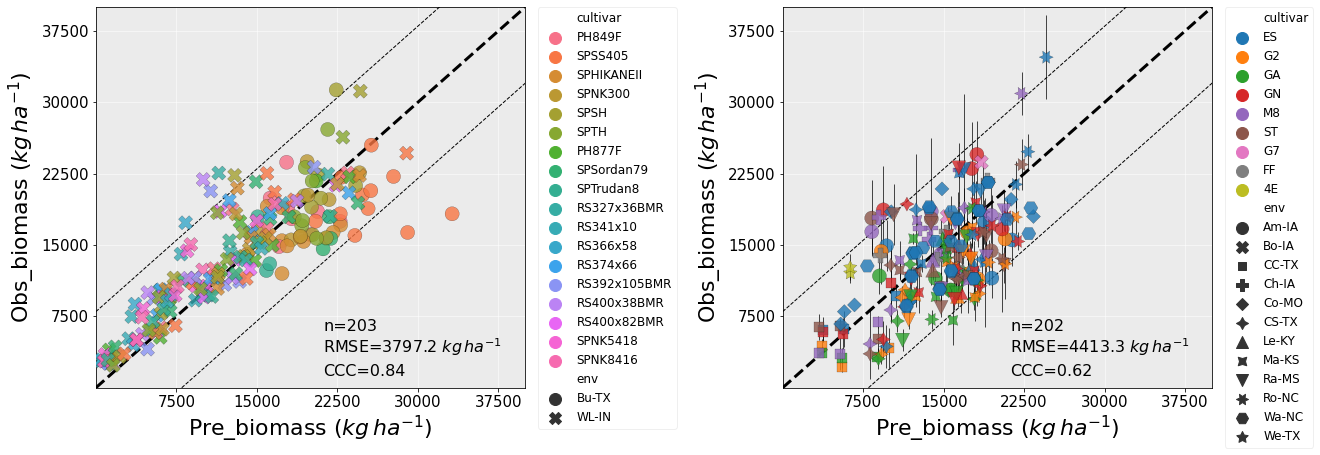

In [503]:
#plot
kwargs  =   {'edgecolor':"k"}
fig = plt.figure(figsize=(20,7))

ax=plt.subplot(1, 2, 1)
xmax=40000
ymax=40000
xmax20=xmax*0.2 
plt.plot([0,xmax],[0,ymax],"--",color="k", linewidth=3,zorder=1)
plt.plot([0,xmax],[xmax20,ymax+xmax20],"--",color="k", linewidth=1,zorder=1)
plt.plot([xmax20,xmax+xmax20],[0,ymax],"--",color="k", linewidth=1,zorder=1)
#ax.errorbar(df['sim_biomass2'], df['obs_biomass'], yerr = df['biomassError'], fmt ='o',marker='',zorder=2,color='k',linewidth=0.7)
sns.scatterplot(x="sim_biomass", y="obs_biomass",hue='cultivar', style='env', alpha=0.8, data=purdue, linewidth=0.2,**kwargs, s=200,zorder=3)

# Formatting graph and background
plt.legend(prop=dict(size=12),bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0., ncol=1,framealpha=0.3,markerscale=2)
plt.ylabel('Obs_biomass ($kg\,ha^{-1}$)', fontsize =22)
plt.xlabel('Pre_biomass ($kg\,ha^{-1}$)', fontsize =22)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.92')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(7500))
ax.yaxis.set_major_locator(ticker.MultipleLocator(7500))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
#ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(purdue.obs_biomass.values)
y_o= Obs.tolist()
Pre = pd.Series(purdue.sim_biomass.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre).round(decimals=1)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
#plt.text(xmax*0.02, ymax*0.9,'(a)',fontsize=22,color='k',weight='bold')
plt.text(xmax*0.53, ymax*0.15,'n='+N,fontsize=16,color='k')
#plt.text(xmax*0.60, ymax*0.2,'MSE='+MSE+' $t\,ha^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.53, ymax*0.09,'RMSE='+RMSE+' $kg\,ha^{-1}$',fontsize=16,color='k')
plt.text(xmax*0.53, ymax*0.03,'CCC='+CCC,fontsize=16,color='k')
#plt.text(xmax*0.45, ymax*0.01,'NSE='+NSE,fontsize=11,color='k')

ax=plt.subplot(1, 2, 2)
xmax=40000
ymax=40000
xmax20=xmax*0.2 
plt.plot([0,xmax],[0,ymax],"--",color="k", linewidth=3,zorder=1)
plt.plot([0,xmax],[xmax20,ymax+xmax20],"--",color="k", linewidth=1,zorder=1)
plt.plot([xmax20,xmax+xmax20],[0,ymax],"--",color="k", linewidth=1,zorder=1)
ax.errorbar(df['sim_biomass2'], df['obs_biomass'], yerr = df['biomassError'], fmt ='o',marker='',zorder=2,color='k',linewidth=0.7)
sns.scatterplot(x="sim_biomass2", y="obs_biomass",hue='cultivar', style='env', alpha=0.8,data=df,linewidth=0.2,**kwargs, s=200,zorder=3)

# Formatting graph and background
plt.legend(prop=dict(size=12),bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0., ncol=1,framealpha=0.3,markerscale=2)
plt.ylabel('Obs_biomass ($kg\,ha^{-1}$)', fontsize =22)
plt.xlabel('Pre_biomass ($kg\,ha^{-1}$)', fontsize =22)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.92')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(7500))
ax.yaxis.set_major_locator(ticker.MultipleLocator(7500))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
#ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(df.obs_biomass.values)
y_o= Obs.tolist()
Pre = pd.Series(df.sim_biomass2.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre).round(decimals=1)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
#plt.text(xmax*0.02, ymax*0.9,'(a)',fontsize=22,color='k',weight='bold')
plt.text(xmax*0.53, ymax*0.15,'n='+N,fontsize=16,color='k')
#plt.text(xmax*0.60, ymax*0.2,'MSE='+MSE+' $t\,ha^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.53, ymax*0.09,'RMSE='+RMSE+' $kg\,ha^{-1}$',fontsize=16,color='k')
plt.text(xmax*0.53, ymax*0.03,'CCC='+CCC,fontsize=16,color='k')
#plt.text(xmax*0.45, ymax*0.01,'NSE='+NSE,fontsize=11,color='k')

####################################################################
plt.subplots_adjust(wspace=0.6, hspace=0.25)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Validation\Figs\val2.png', dpi=300,bbox_inches='tight')

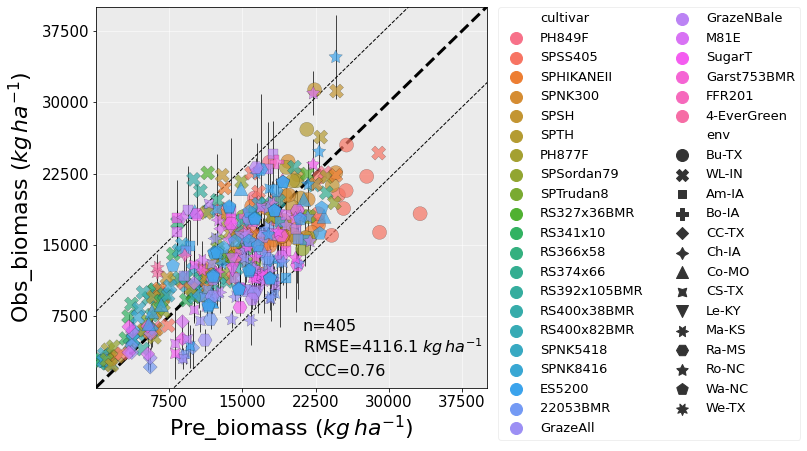

In [509]:
#read all data
final = pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Validation\all.csv')

#plot
kwargs  =   {'edgecolor':"k"}
fig = plt.figure(figsize=(7,7))

ax=plt.subplot(1, 1, 1)
xmax=40000
ymax=40000
xmax20=xmax*0.2 
plt.plot([0,xmax],[0,ymax],"--",color="k", linewidth=3,zorder=1)
plt.plot([0,xmax],[xmax20,ymax+xmax20],"--",color="k", linewidth=1,zorder=1)
plt.plot([xmax20,xmax+xmax20],[0,ymax],"--",color="k", linewidth=1,zorder=1)
ax.errorbar(df['sim_biomass'], df['obs_biomass'], yerr = df['biomassError'], fmt ='o',marker='',zorder=2,color='k',linewidth=0.7)
sns.scatterplot(x="sim_biomass", y="obs_biomass",hue='cultivar', style='env', alpha=0.7, data=final, linewidth=0.2,**kwargs, s=200,zorder=3)

# Formatting graph and background
plt.legend(prop=dict(size=13),bbox_to_anchor=(1.03, 1), loc=2, borderaxespad=0., ncol=2,framealpha=0.3,markerscale=2)
plt.ylabel('Obs_biomass ($kg\,ha^{-1}$)', fontsize =22)
plt.xlabel('Pre_biomass ($kg\,ha^{-1}$)', fontsize =22)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.92')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.xaxis.set_major_locator(ticker.MultipleLocator(7500))
ax.yaxis.set_major_locator(ticker.MultipleLocator(7500))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
ax.set_xlim([0.01,xmax])
ax.set_ylim([0.01,ymax])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
#ax.get_legend().remove()

#Taking data from dataframe to a list
Obs = pd.Series(final.obs_biomass.values)
y_o= Obs.tolist()
Pre = pd.Series(final.sim_biomass.values)
y_p= Pre.tolist()

#Converting from a list to an arange
y_obs = array(y_o).round(decimals=2)
y_pre = array(y_p).round(decimals=2)

def rmse(y_obs, y_pre):
    """ Compute RMSE between two time series """
    return np.sqrt(np.mean(np.square(y_pre - y_obs))).round(decimals=2)

def mse(y_true, y_pre):
    """ Compute MSE between two time series """
    return np.mean(np.square(y_pre - y_true)).round(decimals=2)

def ccc(y_true, y_pre):
    """ Compute the concordance correlation coefficient (CCC) between two
    1D time series """
    if y_true.ndim == 1:
        y_true = y_true.reshape(1, -1)
    if y_pre.ndim == 1:
        y_pre = y_pre.reshape(1, -1)
    cov_xy = np.mean(y_pre*y_true, axis=1) - \
        (np.mean(y_pre, axis=1) * np.mean(y_true, axis=1))
    mean_x = np.mean(y_pre, axis=1)
    mean_y = np.mean(y_true, axis=1)
    var_x = np.var(y_pre, axis=1)
    var_y = np.var(y_true, axis=1)
    return (2*cov_xy/(var_x + var_y + np.square(mean_x - mean_y)))[0].round(decimals=2)

#Get the values
N=str(Obs.count())

MSEb=mse(y_obs, y_pre)
MSE=str(MSEb)

RMSEb=rmse(y_obs, y_pre).round(decimals=1)
RMSE=str(RMSEb)

SumOfSquaredResiduals=((np.square(y_pre - y_obs))).sum()
SumOfSquaredSD=(np.square(y_obs-(np.mean(y_obs)))).sum()
NSEb = (1 - SumOfSquaredResiduals / SumOfSquaredSD).round(decimals=2)
NSE=str(NSEb)

CCCb=ccc(y_obs, y_pre)
CCC=str(CCCb)

#Plot statistical values
#plt.text(xmax*0.02, ymax*0.9,'(a)',fontsize=22,color='k',weight='bold')
plt.text(xmax*0.53, ymax*0.15,'n='+N,fontsize=16,color='k')
#plt.text(xmax*0.60, ymax*0.2,'MSE='+MSE+' $t\,ha^{-1}$',fontsize=11,color='k')
plt.text(xmax*0.53, ymax*0.09,'RMSE='+RMSE+' $kg\,ha^{-1}$',fontsize=16,color='k')
plt.text(xmax*0.53, ymax*0.03,'CCC='+CCC,fontsize=16,color='k')
#plt.text(xmax*0.45, ymax*0.01,'NSE='+NSE,fontsize=11,color='k')

####################################################################
plt.subplots_adjust(wspace=0.6, hspace=0.25)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Validation\Figs\val.png', dpi=300,bbox_inches='tight')

In [495]:
df.loc[df['delta'] > 8000]

,date,day,DaysAfterSowing,sim_biomass,stage,StageName,TotalTT(),Title,name,env,...,state,location,cultivar,year,nitrogen,year2,obs_biomass,biomassError,delta,sim_biomass2
15,09/15/2012,259.0,118.0,9384.0,8.808,start_grain_fill,1294.447,Am_IA_GN_N200_Y_ALL,IA_Am_GN_2012_N200_Y_ALL,Am-IA,...,IA,Am,GN,2012,N200,Y_ALL,18694.9,4564.8,9310.9,9384.0
19,09/15/2012,259.0,118.0,8302.8,6.044,flag_leaf,1177.676,Am_IA_M8_N200_Y_ALL,IA_Am_M8_2012_N200_Y_ALL,Am-IA,...,IA,Am,M8,2012,N200,Y_ALL,16401.7,2314.4,8098.9,8302.8
23,09/15/2012,259.0,118.0,8302.8,6.044,flag_leaf,1177.676,Am_IA_ST_N200_Y_ALL,IA_Am_ST_2012_N200_Y_ALL,Am-IA,...,IA,Am,ST,2012,N200,Y_ALL,17829.8,4008.1,9527.0,8302.8
54,09/15/1988,259.0,118.0,8941.9,6.673,flag_leaf,1293.389,Ch_IA_M8_N200_Y_ALL,IA_Ch_M8_1988_N200_Y_ALL,Ch-IA,...,IA,Ch,M8,1988,N200,Y_ALL,17900.0,NaN,8958.1,8941.9
61,10/25/2010,298.0,130.0,10120.5,5.926,floral_initiation,989.489,Co_MO_ES_N056_Y2010,MO_Co_ES_2010_N056_Y2010,Co-MO,...,MO,Co,ES,2010,N056,Y2010,18500.0,NaN,8379.5,10120.5
157,10/01/2009,274.0,115.0,24557.1,8.805,start_grain_fill,1570.570,Ro_NC_ES_N200_Y_ALL,NC_Ro_ES_2009_N200_Y_ALL,Ro-NC,...,NC,Ro,ES,2009,N200,Y_ALL,34744.7,4401.5,10187.6,24557.1
173,10/01/2009,274.0,115.0,22261.0,8.413,start_grain_fill,1570.570,Ro_NC_M8_N200_Y_ALL,NC_Ro_M8_2009_N200_Y_ALL,Ro-NC,...,NC,Ro,M8,2009,N200,Y_ALL,30932.0,2296.7,8671.0,22261.0
212,12/31/2009,365.0,257.0,4608.5,8.983,start_grain_fill,1526.052,We_TX_4E_N000_Y2009,TX_We_4E_2009_N000_Y2009,We-TX,...,TX,We,4E,2009,N000,Y2009,28389.9,2663.0,23781.4,4608.5
213,12/31/2009,365.0,263.0,10095.5,11.000,harvest_ripe,1797.561,We_TX_4E_N280_Y2009,TX_We_4E_2009_N280_Y2009,We-TX,...,TX,We,4E,2009,N280,Y2009,23587.0,2282.6,13491.5,10095.5
